# Filament identification using CRISPy

We first try CRISPy with the data as they are (a large bg cloud with several filaments) in a small sector to see if CRISPy can separate the large cloud from the small gas flows over and under it in ppv space. Then we can test with the data minus the large cloud

In [1]:
import numpy as np 
import sys
sys.path.append('../')
from setup import *
import os
from crispy import image_ridge_find, grid_ridge
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.modeling.models import Gaussian1D, Const1D
from spectral_cube import SpectralCube
from skimage.morphology import remove_small_objects, label
%matplotlib widget

In [2]:
deblendedname = 'deblended_HC3N_bayes.fits'
ridgetextfilename = 'ridges_coords_bayes.txt'
fitsfileridges = 'ridges_map3d_bayes.fits'
show3dplots = True
mask_small_objects = True
masked_npeakfile = bayesnpeaksfile[:-5] + '_masked.fits'
threshold = 0.1 # K
walkerthr = 0.2

In [3]:
# first we build a deblended cube
originalcube = SpectralCube.read(hc3n_10_9_cube+'.fits')
originalcube = originalcube.spectral_slab(-4.8 * u.km/u.s, 20 * u.km/u.s)
headercube = originalcube.header
wcshead = WCS(headercube)
chanwidth = np.abs(headercube['cdelt3'])

# Nyquist sampling: 2 times the highest frequency of the signal
# so if the FWHM is X, the channel width must be 2X/2.35
newsigma = 2.35 / 2 * chanwidth

# we need the gaussian components for the deblended cube
ncomponentsmap, ncomphead = fits.getdata(bayesnpeaksfile, header=True) #fits.getdata(fitdir+'diagnosticAIC/ncomponents_AIC.fits')
params1gmap = fits.getdata(bayesfitfilebase.format(1))
params2gmap = fits.getdata(bayesfitfilebase.format(2))
params3gmap = fits.getdata(bayesfitfilebase.format(3))

paramdict = {1:params1gmap, 2:params2gmap, 3:params3gmap}

if mask_small_objects:
    if not os.path.exists(masked_npeakfile):
        bmaj, bmin = np.array([headercube['bmaj'], headercube['bmin']]) / np.abs(headercube['cdelt2'])
        equivsize = 1.133 * bmaj * bmin #area of one beam
        maskmap = (np.where(~np.isnan(ncomponentsmap), 1, 0) * np.where(ncomponentsmap !=0, 1, 0)).astype(bool)
        maskmap = remove_small_objects(maskmap, int(round(equivsize, 0)))
        ncomponentsmap = np.where(maskmap, ncomponentsmap, np.nan)
        fits.writeto(masked_npeakfile, ncomponentsmap, ncomphead)
    else:
        ncomponentsmap = fits.getdata(masked_npeakfile)

In [4]:

if not os.path.exists(deblendedname):
    print('Creating deblended cube')
    npixx = headercube['NAXIS1']
    npixy = headercube['NAXIS2']
    npixv = headercube['NAXIS3']
    
    velarray = originalcube.spectral_axis.value

    newcube = np.zeros((npixv, npixy, npixx))
    for y in range(npixy):
        for x in range(npixx):
            ncomp = ncomponentsmap[y, x]
            if np.isnan(ncomp): continue
            else:
                ncomp = int(ncomp)
                if ncomp == 1:
                    gmodel = Gaussian1D(paramdict[ncomp][0, y, x], paramdict[ncomp][1, y, x], newsigma)
                else:
                    gmodel = Const1D(amplitude=0)
                    for i in range(ncomp): 
                        gmodel += Gaussian1D(paramdict[ncomp][0+3*i, y, x], paramdict[ncomp][1+3*i, y, x], newsigma)
                    # gmodel = [Gaussian1D(paramdict[ncomp][0+3*i, y, x], paramdict[ncomp][1+3*i, y, x], newsigma) for i in range(ncomp)]
                    # gmodel = np.sum(gmodel, axis=0)
                        #gmodel = Gaussian1D(params2gmap[0, y, x], params2gmap[1, y, x], newsigma) + Gaussian1D(params2gmap[3, y, x], params2gmap[4, y, x], newsigma)
                
            newcube[:, y, x] = gmodel(velarray)
            
    fits.writeto(deblendedname, newcube, headercube)
else:
    print('Opening deblended cube')
    newcube = fits.getdata(deblendedname)

Opening deblended cube


In [5]:

if not os.path.exists('test_cube.fits'):
    sc = SpectralCube.read(deblendedname)
    testcube = sc[:, 200:250, 185:245]
    headertest = testcube.header
    testcube.write('test_cube.fits')
else:
    testcube = SpectralCube.read('test_cube.fits')
    headertest = testcube.header


In [6]:
# here we test CRISPy

if not os.path.exists(ridgetextfilename):
    ridges_coords = image_ridge_find.run('test_cube.fits', h=1.5, thres=threshold, ordXYZ=False, walkerThres=walkerthr, ncpu=5)
    image_ridge_find.write_output(ridges_coords, ridgetextfilename)
    if ridges_coords.ndim !=2:
        ridges_coords = ridges_coords.reshape(ridges_coords.shape[0:2])
else:
    ridges_coords =  grid_ridge.read_table(ridgetextfilename)


In [7]:
ridges_coords

array([[50.73666972, 50.02644374, 50.00821496, ..., 84.11488042,
        84.11759604, 84.14909825],
       [46.3442479 ,  7.41054668,  7.4118277 , ..., 24.39208564,
        25.21011304, 25.6043898 ],
       [41.3741345 ,  4.24014121,  4.24147589, ..., 42.90929463,
        46.90426611, 48.46010782]])

In [8]:
if not os.path.exists(fitsfileridges):
    
    ridges_cube = grid_ridge.grid_skeleton(ridges_coords, testcube.unmasked_data[:,:,:])
    grid_ridge.write_skel(fitsfileridges, ridges_cube, headertest)
else:
    ridges_cube = fits.getdata(fitsfileridges)

In [9]:
# index_ridges = np.flip(np.where(ridges_cube > 0), axis=0)
# wcs_ridges = np.transpose(WCS(headertest).all_pix2world(np.transpose(index_ridges), 0))

# if show3dplots:
#     fig = plt.figure(figsize=(10,10))
#     ax = fig.add_subplot(111,projection='3d')

#     ax.scatter(wcs_ridges[0], wcs_ridges[1], wcs_ridges[2], alpha=0.8)
#     ax.set_xlabel('ra')
#     ax.set_ylabel('dec')
#     ax.set_zlabel('v')

Now that we have the ridges, we can look for the splines

In [10]:
spinecube = grid_ridge.clean_grid_ppv(ridges_coords, testcube.unmasked_data[:,:,:], min_length=4)

---gridding 45 distinct skeletons---


/home/mvaldivi/miniconda3/lib/python3.8/site-packages/astro_crispy-1.0.0-py3.8.egg/crispy/grid_ridge.py:156: FutureWarning: `selem` is a deprecated argument name for `binary_dilation`. It will be removed in version 1.0. Please use `footprint` instead.
/home/mvaldivi/miniconda3/lib/python3.8/site-packages/astro_crispy-1.0.0-py3.8.egg/crispy/grid_ridge.py:177: FutureWarning: in_place argument is deprecated and will be removed in version 1.0. To avoid this warning, please do not use the in_place argument. Please see remove_small_objects documentation for more details. Please use out argument instead.


In [11]:
grid_ridge.write_skel('spine_cube_bayes.fits', spinecube, headertest)

In [18]:
labels, numlabels =label(spinecube, return_num=True)

In [19]:
numlabels

16

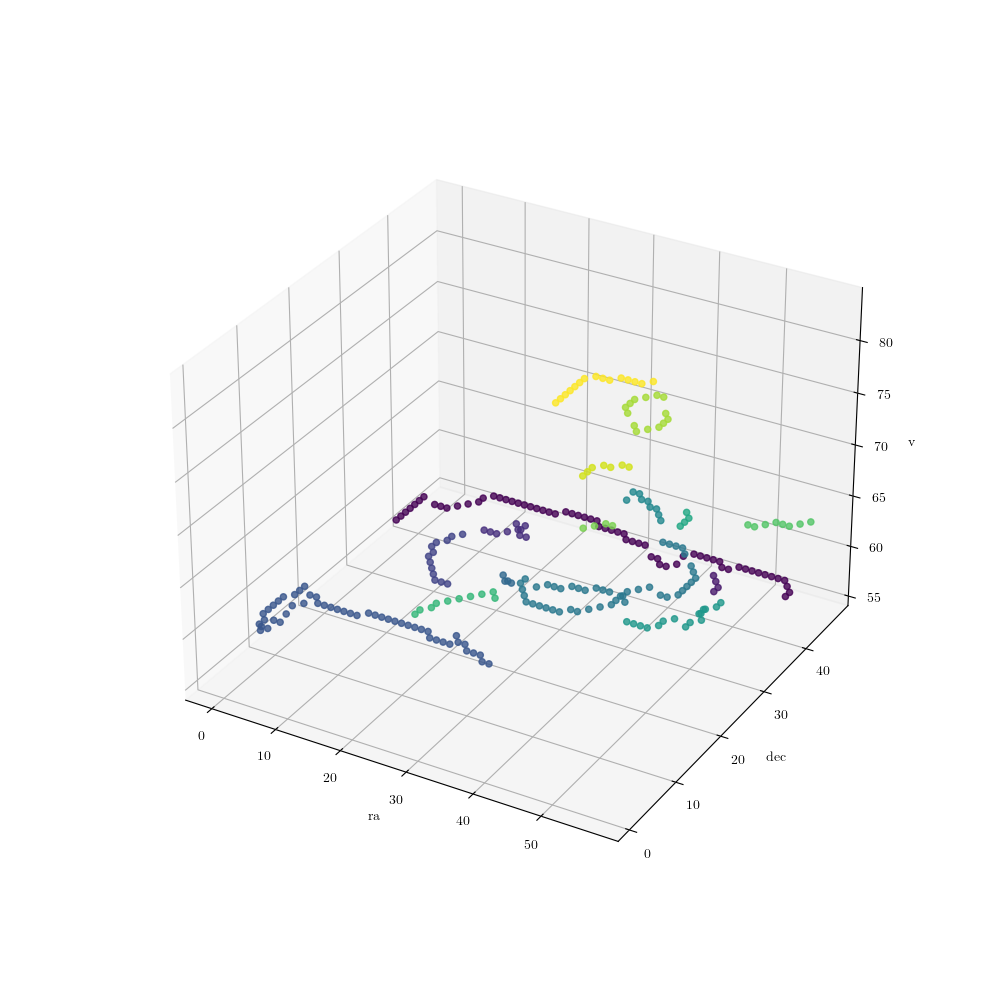

In [20]:
index_ridges = np.flip(np.where(spinecube), axis=0)
labcolor = labels[np.where(spinecube)]
wcs_ridges = np.transpose(WCS(headertest).all_pix2world(np.transpose(index_ridges), 0))

if show3dplots:
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111,projection='3d')

    ax.scatter(index_ridges[0], index_ridges[1], index_ridges[2], alpha=0.8, c=labcolor)
    ax.set_xlabel('ra')
    ax.set_ylabel('dec')
    ax.set_zlabel('v')